# <center>CQF Exam Three<center>
#### <center>June 2022 Cohort<center>
#### <center>Zhizhao Wang<center>

### This notebook file is an auxiliary file with codes and plots for the Exam 3 main report.

In [1]:
# Base Libraries
import pandas as pd
import numpy as np
import datetime
import random
import yfinance as yf

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,6)
plt.style.use('fivethirtyeight')

# scikit learn packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.pipeline import Pipeline

# Metrics
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, plot_confusion_matrix, plot_roc_curve

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set display options
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

In [3]:
# For reproducibility
random.seed(100)
np.random.seed(100)

### B.1 Understand and Collect the data

In [201]:
# download the 10 years Gold ETF from 2012-10-01 to 2022-10-01
# df = yf.download('GLD', '2012-10-01','2022-10-01', progress=False)
# pd.DataFrame(df).to_csv('GLD.csv')

In [202]:
# load the data saved locally
data = pd.read_csv('GLD.csv')
data['Date'] = pd.to_datetime(pd.to_datetime(data['Date']).apply(lambda x:x.strftime('%Y-%m-%d')))
data.set_index('Date', inplace=True)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-10-01,172.830002,173.619995,171.770004,172.289993,172.289993,10676400
2012-10-02,172.470001,172.699997,171.589996,172.100006,172.100006,7053900
2012-10-03,172.509995,172.610001,171.889999,172.410004,172.410004,5647600
2012-10-04,173.199997,174.070007,172.919998,173.610001,173.610001,10376800
2012-10-05,172.869995,173.369995,172.009995,172.619995,172.619995,8871000


In [203]:
data.shape

(2517, 6)

In [204]:
data.isnull().sum()  

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

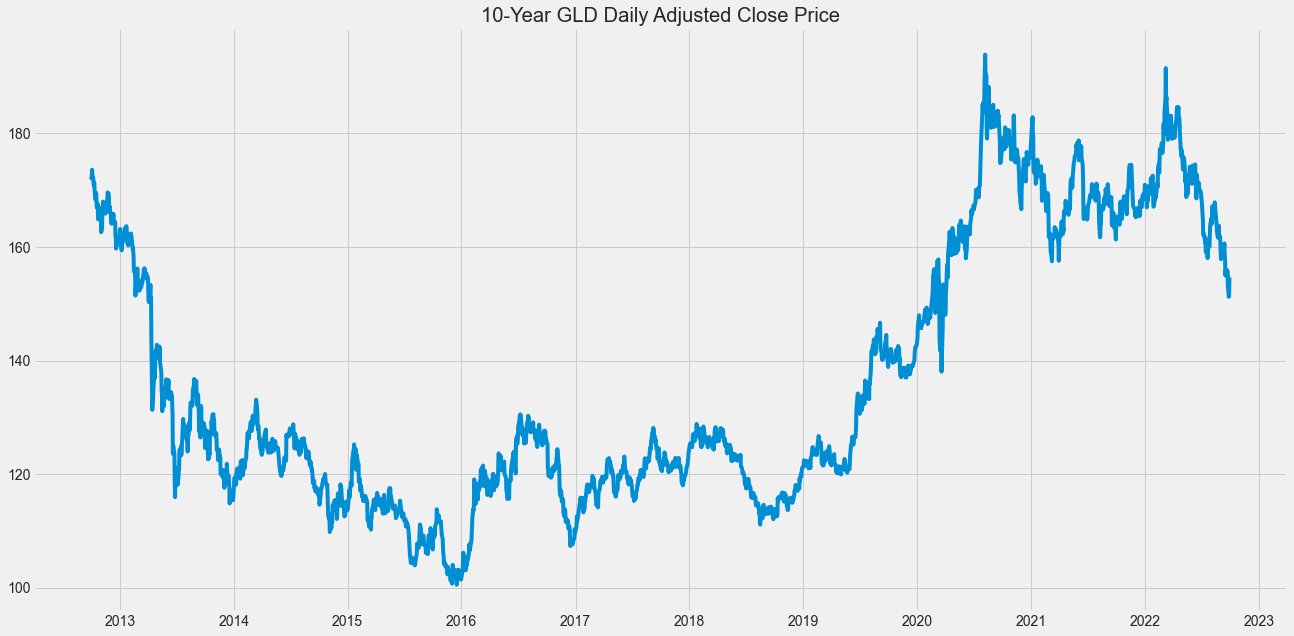

In [205]:
# Plot of 10 years GLD price trend
plt.figure(figsize=(20,10))
plt.plot(data['Adj Close'])
plt.title('10-Year GLD Daily Adjusted Close Price');

### B.2 Data Exploration

- **B.2.1 Daily Return (1D_Return)**

In [206]:
# generate the one-day return
data['1D_Return'] = np.log(data['Adj Close'])-np.log(data['Adj Close'].shift(1))
data.head()

,Open,High,Low,Close,Adj Close,Volume,1D_Return
Date,,,,,,,
2012-10-01,172.830002,173.619995,171.770004,172.289993,172.289993,10676400,NaN
2012-10-02,172.470001,172.699997,171.589996,172.100006,172.100006,7053900,-0.001103
2012-10-03,172.509995,172.610001,171.889999,172.410004,172.410004,5647600,0.001800
2012-10-04,173.199997,174.070007,172.919998,173.610001,173.610001,10376800,0.006936
2012-10-05,172.869995,173.369995,172.009995,172.619995,172.619995,8871000,-0.005719


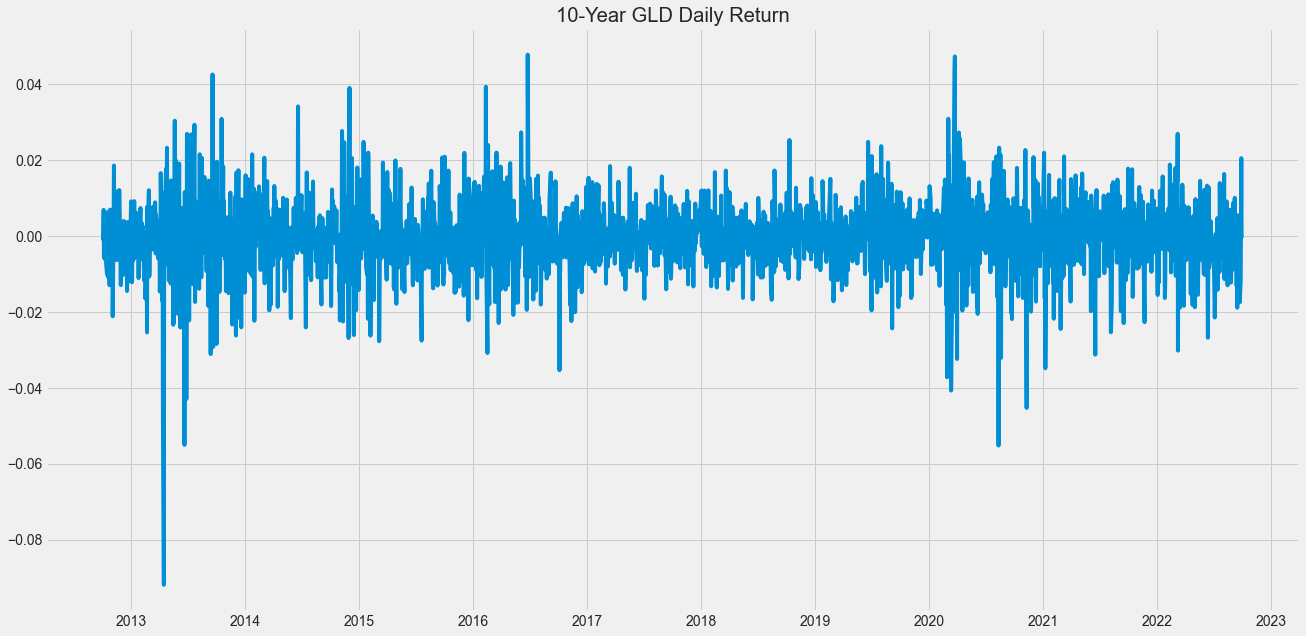

In [207]:
# Plot of 10 years of GLD daily return
plt.figure(figsize=(20,10))
plt.plot(data['1D_Return'])
plt.title('10-Year GLD Daily Return');

Text(0.5, 1.0, 'GLD Daily Return Histogram & Normal Distribution')

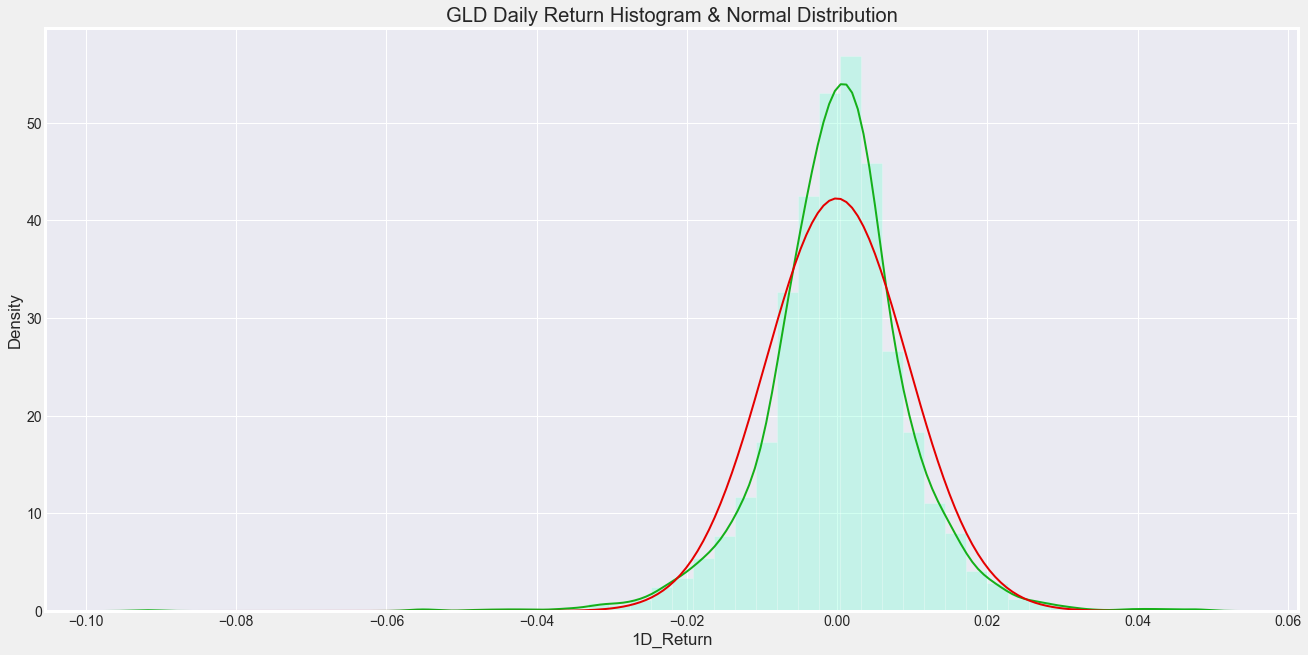

In [208]:
# Plot of GLD daily return histogram compared with normal distribution
from scipy.stats import norm

plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
sns.distplot(data['1D_Return'].dropna(), 
             kde_kws={'linewidth':'2','color':'#15b01a'},
             fit=norm,
             fit_kws={'linewidth':'2','color':'#e50000'},
             color='#8cffdb')
plt.title('GLD Daily Return Histogram & Normal Distribution')

Text(0.5, 1.0, 'GLD Daily Return Autocorrelation coefficients')

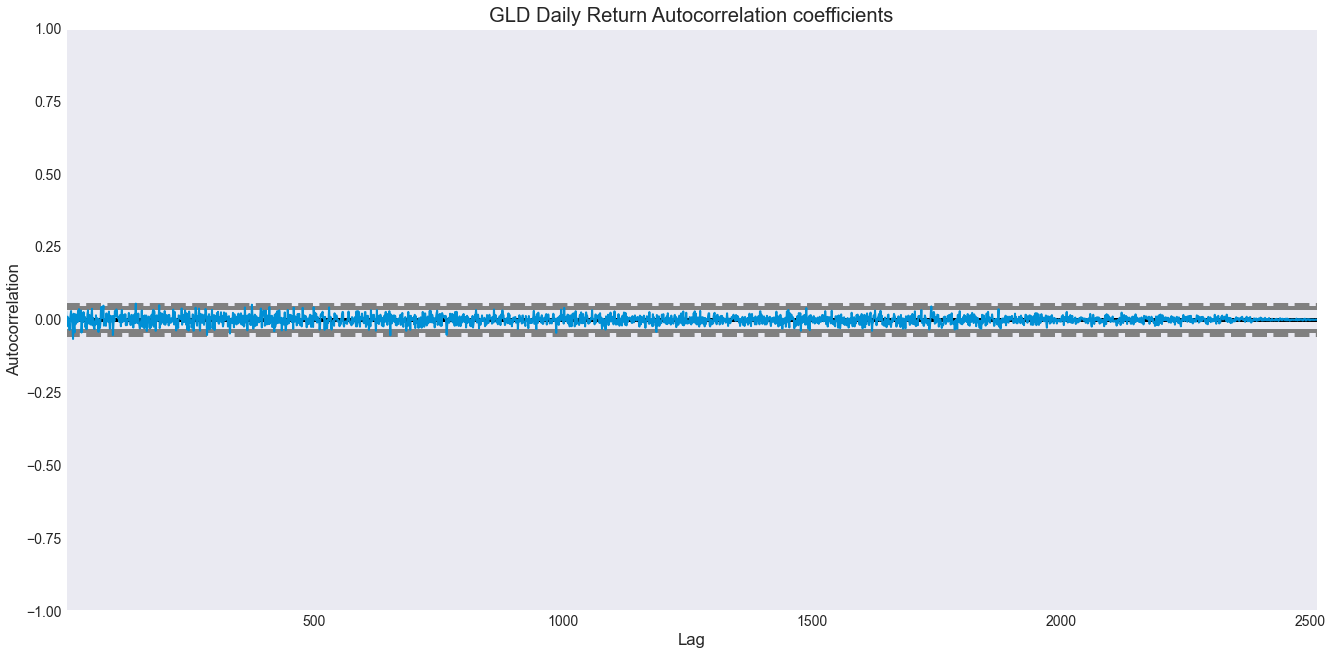

In [209]:
# plot of auto-correlation of the daily return (all possible lags)
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
autocorrelation_plot(data['1D_Return'].dropna(), linewidth=2.0)
plt.title('GLD Daily Return Autocorrelation coefficients')

Text(0.5, 1.0, 'GLD Daily Return Autocorrelation coefficients (2)')

<Figure size 1440x720 with 0 Axes>

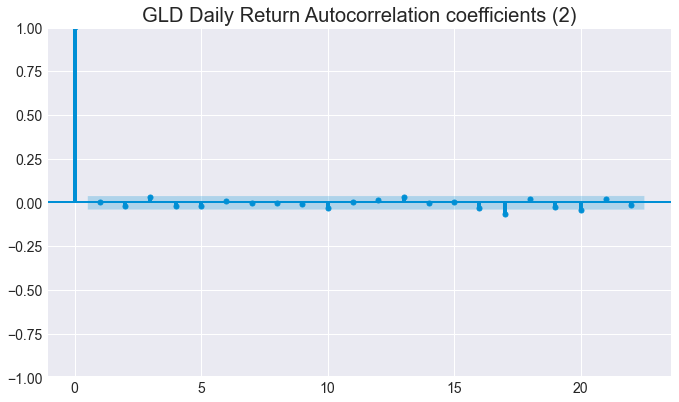

In [210]:
# plot of auto-correlation of the daily return (max lag of 22)
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
plot_acf(data['1D_Return'].dropna(),lags=22, linewidth=2.0);
plt.title('GLD Daily Return Autocorrelation coefficients (2)')

- **B.2.2 Model Target (Target)**

In [211]:
# Mean of the return
data['1D_Return'].mean() * 100

-0.004287967462810704

In [212]:
# Median of the return
data['1D_Return'].median() * 100

0.029409643681965747

In [213]:
# set the target
data['Target'] = np.where(data['1D_Return'] > data['1D_Return'].median(),1,0)
data['Target'] = data['Target'].shift(-1)
data.head()

,Open,High,Low,Close,Adj Close,Volume,1D_Return,Target
Date,,,,,,,,
2012-10-01,172.830002,173.619995,171.770004,172.289993,172.289993,10676400,NaN,0.0
2012-10-02,172.470001,172.699997,171.589996,172.100006,172.100006,7053900,-0.001103,1.0
2012-10-03,172.509995,172.610001,171.889999,172.410004,172.410004,5647600,0.001800,1.0
2012-10-04,173.199997,174.070007,172.919998,173.610001,173.610001,10376800,0.006936,0.0
2012-10-05,172.869995,173.369995,172.009995,172.619995,172.619995,8871000,-0.005719,0.0


### B.3 Feature Engineering

- **B.3.1 Feature Generation**

    - B.3.1.1 Intraday Price Range

In [214]:
# O-C
data['O-C'] = data['Open'] - data['Close']
# H-L
data['H-L'] = data['High'] - data['Low']

    - B.3.1.2 Sign of Return

In [215]:
data['Sign'] = np.where(data['1D_Return'] > 0, 1, -1)

    - B.3.1.3 Past Returns

In [216]:
# lagged returns for 1, 5, 22
for n in (1, 5, 22):
    data[str(n)+'D_LagReturn'] = data['1D_Return'].shift(n)

    - B.3.1.4 Momentum

In [217]:
# Price change over periods of 1, 5, 22
for n in (1, 5, 22):
    data[str(n)+'D_Momentum'] = data['Adj Close'] - data['Adj Close'].shift(n)

    - B.3.1.5 Simple Moving Average

In [218]:
# Simple moving average of prices over periods of 3, 5, 10, 15, 22
for n in(3, 5, 10, 15, 22):
    data[str(n)+'D_SMA'] = data['Adj Close'].rolling(n).mean()

    - B.3.1.6 Exponential Moving Average

In [219]:
# Exponential moving average with beta = 0.1, 0.3, 0.5, 0.7 and 0.9
def EMA(data, beta):
    ema = [data['Adj Close'][0]]
    for i in range(1, len(data['Adj Close'])):
        ema.append(beta*ema[i-1] + (1-beta)*data['Adj Close'][i])
    return ema

for beta in (0.1, 0.3, 0.5, 0.7, 0.9):
    ema = EMA(data, beta)
    data[str(beta) + '_EMA'] = ema

    - B.3.1.7 Cumulative Return

In [220]:
# Cumulative return over periods of 5,10,22
for n in(5, 10, 15, 22):
    data[str(n)+'D_CR'] = data['1D_Return'].rolling(n).sum()

In [221]:
cols = data.drop('Target',axis=1).columns
cols

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '1D_Return', 'O-C', 'H-L', 'Sign', '1D_LagReturn', '5D_LagReturn', '22D_LagReturn', '1D_Momentum', '5D_Momentum', '22D_Momentum', '3D_SMA', '5D_SMA', '10D_SMA', '15D_SMA', '22D_SMA', '0.1_EMA', '0.3_EMA', '0.5_EMA', '0.7_EMA', '0.9_EMA', '5D_CR', '10D_CR', '15D_CR', '22D_CR'], dtype='object')

In [222]:
len(cols)

30

- **B.3.2 Feature Selection**

- B.3.2.1 Random Forest Feature Importance

In [233]:
# Random forest importance for feature selection - Find the best parameters
fs_X = data.dropna().drop("Target",axis=1)
fs_y = data.dropna()["Target"]

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

# Perform Gridsearch and fit
param_grid = {"n_estimators":[5,10,20,30,40,50],
             "max_depth":[2,4,6,8,10,20,30]}

fs_model = GridSearchCV(RandomForestClassifier(), param_grid, n_jobs=-1, cv=tscv, verbose=1, scoring='roc_auc')
fs_model.fit(fs_X, fs_y)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10, 20, 30],
                         'n_estimators': [5, 10, 20, 30, 40, 50]},
             scoring='roc_auc', verbose=1)

In [234]:
# Best Params and Best scores
fs_model.best_params_ , fs_model.best_score_

({'max_depth': 2, 'n_estimators': 10}, 0.5226771130712995)

Text(0.5, 1.0, 'Feature Importances From Random Forest Model')

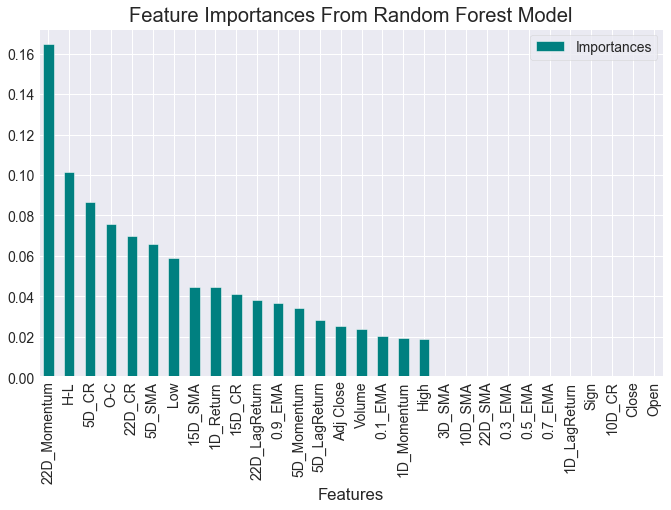

In [235]:
# Random forest importance for feature selection - Fearure Importance
fs_X = data.dropna().drop("Target",axis=1)
fs_y = data.dropna()["Target"]

model = RandomForestClassifier(n_estimators=10,max_depth=2,random_state=1)
model.fit(fs_X, fs_y)
importances = model.feature_importances_

# visualization of feature importance
fs_importance = pd.DataFrame({"Features":cols, "Importances":importances}).set_index("Features")
fs_importance = fs_importance.sort_values("Importances", ascending=False)

fs_importance.plot.bar(color='teal')
plt.title("Feature Importances From Random Forest Model")

In [236]:
fs_importance

,Importances
Features,
22D_Momentum,0.164638
H-L,0.101510
5D_CR,0.086497
O-C,0.075872
22D_CR,0.069832
5D_SMA,0.065871
Low,0.058789
15D_SMA,0.044744
1D_Return,0.044460


In [237]:
data.drop(list(fs_importance[fs_importance['Importances']==0].index),axis=1, inplace = True)
data.head()

,High,Low,Adj Close,Volume,1D_Return,Target,O-C,H-L,5D_LagReturn,22D_LagReturn,1D_Momentum,5D_Momentum,22D_Momentum,5D_SMA,15D_SMA,0.1_EMA,0.9_EMA,5D_CR,15D_CR,22D_CR
Date,,,,,,,,,,,,,,,,,,,,
2012-10-01,173.619995,171.770004,172.289993,10676400,NaN,0.0,0.540009,1.849991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.289993,172.289993,NaN,NaN,NaN
2012-10-02,172.699997,171.589996,172.100006,7053900,-0.001103,1.0,0.369995,1.110001,NaN,NaN,-0.189987,NaN,NaN,NaN,NaN,172.119005,172.270995,NaN,NaN,NaN
2012-10-03,172.610001,171.889999,172.410004,5647600,0.001800,1.0,0.099991,0.720001,NaN,NaN,0.309998,NaN,NaN,NaN,NaN,172.380904,172.284895,NaN,NaN,NaN
2012-10-04,174.070007,172.919998,173.610001,10376800,0.006936,0.0,-0.410004,1.150009,NaN,NaN,1.199997,NaN,NaN,NaN,NaN,173.487091,172.417406,NaN,NaN,NaN
2012-10-05,173.369995,172.009995,172.619995,8871000,-0.005719,0.0,0.250000,1.360001,NaN,NaN,-0.990005,NaN,NaN,172.606,NaN,172.706705,172.437665,NaN,NaN,NaN


- B.3.2.2 SHAP

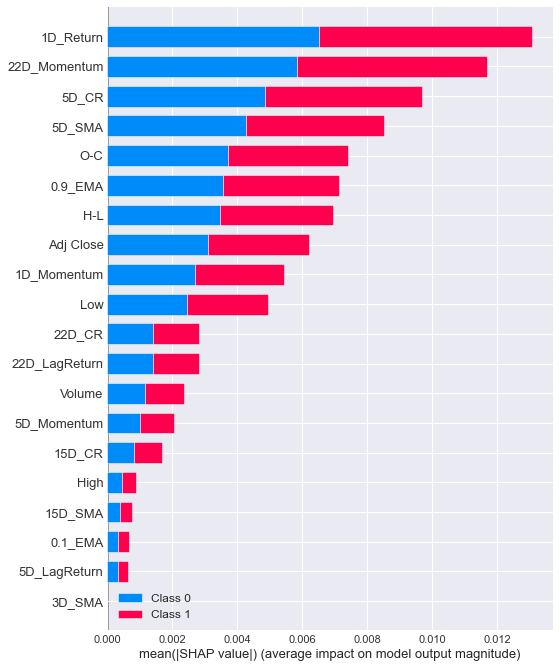

In [238]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(fs_X)
# interpretation plot
shap.summary_plot(shap_values, fs_X)

- B.3.2.3 Multicolinearity

- B.3.2.4 ANOVA & t-test

In [239]:
# Analysis of Variance & t-test
from scipy import stats
# Divide the dataset according to the target into two groups
df1 = data.dropna()[data['Target']==1].drop('Target', axis=1)
df0 = data.dropna()[data['Target']==0].drop('Target', axis=1)

In [240]:
# Analysis of Variance & t-test
features, fs, fps, ts, tps = [], [], [], [], []

for feature in data.dropna().drop('Target', axis=1).columns:
    args = [list(df0[feature])]
    args.append(list(df1[feature]))
    # ANOVA
    f, p = stats.f_oneway(*args)
    features.append(feature)
    fs.append(f)
    fps.append(p)
    # t-test
    t, pval = stats.ttest_ind(*args)
    ts.append(t)
    tps.append(pval)
    
        
test = pd.DataFrame({"Features": features,
                     "F": fs,
                     "ANOVA p": fps,
                      "t": ts,
                      "t-test p": tps}).set_index("Features")
test.sort_values("F", ascending = False, inplace= True)
test

,F,ANOVA p,t,t-test p
Features,,,,
1D_Return,5.354165,0.020754,2.313907,0.020754
1D_Momentum,3.632961,0.056761,1.906033,0.056761
22D_CR,3.347360,0.067432,1.829579,0.067432
22D_Momentum,3.153296,0.075896,1.775752,0.075896
O-C,2.697328,0.100643,-1.642354,0.100643
15D_CR,1.772359,0.183212,1.331300,0.183212
5D_LagReturn,1.171888,0.279118,-1.082538,0.279118
5D_Momentum,0.658139,0.417295,0.811257,0.417295
Volume,0.517748,0.471872,-0.719547,0.471872


In [241]:
list(test[test['ANOVA p']>0.1].index)

['O-C',
 '15D_CR',
 '5D_LagReturn',
 '5D_Momentum',
 'Volume',
 '5D_CR',
 'H-L',
 '22D_LagReturn',
 '0.9_EMA',
 '15D_SMA',
 '5D_SMA',
 'Low',
 'High',
 '0.1_EMA',
 'Adj Close']

In [242]:
data.drop(list(test[test['ANOVA p']>0.1].index),axis=1, inplace=True)
data.head()

,1D_Return,Target,1D_Momentum,22D_Momentum,22D_CR
Date,,,,,
2012-10-01,NaN,0.0,NaN,NaN,NaN
2012-10-02,-0.001103,1.0,-0.189987,NaN,NaN
2012-10-03,0.001800,1.0,0.309998,NaN,NaN
2012-10-04,0.006936,0.0,1.199997,NaN,NaN
2012-10-05,-0.005719,0.0,-0.990005,NaN,NaN


### B.4 Clean and Transform data

In [243]:
# clean data and save locally
data.dropna(inplace=True)
# data.to_csv('GLD_cleaned.csv', index=True)

In [4]:
data = pd.read_csv('GLD_cleaned.csv', index_col=0)
data.head()

,1D_Return,Target,1D_Momentum,22D_Momentum,22D_CR
Date,,,,,
2012-11-02,-0.021116,1.0,-3.470001,-9.689987,-0.057886
2012-11-05,0.003867,1.0,0.629990,-8.870010,-0.052916
2012-11-06,0.018633,1.0,3.070007,-6.110001,-0.036082
2012-11-07,0.001142,1.0,0.190002,-7.119995,-0.041876
2012-11-08,0.008969,0.0,1.500000,-4.629990,-0.027188


In [5]:
X = data.drop("Target", axis=1).values
y = pd.Series(data["Target"]).values

### B.5 Modelling and Hyperparams Tuning

- **B.5.1 General View of SVC and SVM**

In [6]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 1995, 499


In [7]:
# Construct a pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("classifier", SVC(kernel='rbf', C=1000.0, gamma=0.1))]) 
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', SVC(C=1000.0, gamma=0.1))])

In [8]:
# Predicting the test dataset
y_pred = pipe.predict(X_test)
# Metrics 

metrics.roc_auc_score(y_test, y_pred)

0.5221708116444959

- **B.5.2 Hyperparameters Tuning**

In [9]:
# Hyperparameter tuning for SVC

# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

# Perform Gridsearch and fit
param_grid = {"scaler":[StandardScaler(), MinMaxScaler(), RobustScaler()],
              "classifier__C": [0.01, 0.1, 1, 10, 100, 1000, 10000],
              "classifier__kernel": ["linear", "poly", "rbf", "sigmoid"],
              "classifier__gamma": ["scale", "auto", 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1]}

svm_hyper = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=tscv, verbose=1, scoring='roc_auc')
svm_hyper.fit(X_train, y_train)

svm_hyper.best_params_

Fitting 5 folds for each of 756 candidates, totalling 3780 fits


{'classifier__C': 100,
 'classifier__gamma': 'scale',
 'classifier__kernel': 'poly',
 'scaler': StandardScaler()}

In [10]:
# Best score
svm_hyper.best_score_

0.5548617344496359

- **B.5.3 Final Model**

In [13]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Construct a pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("classifier", SVC(kernel='poly', C=100, gamma='scale'))]) 
pipe.fit(X_train, y_train)

# Predicting the test dataset
y_pred = pipe.predict(X_test)

# Metrics 
print("The AUC-ROC score of the final model is ", metrics.roc_auc_score(y_test, y_pred))

The AUC-ROC score of the final model is  0.5248136366557419


### B.6 Validation and Evaluation

- **B.6.1 Accuracy**

In [14]:
# Output prediction score
print(f'Train Accuracy: {pipe.score(X_train,y_train):0.4}')
print(f'Test Accuracy: {pipe.score(X_test,y_test):0.4}')

Train Accuracy: 0.5283
Test Accuracy: 0.5291


- **B.6.2 Confusion Matrix**

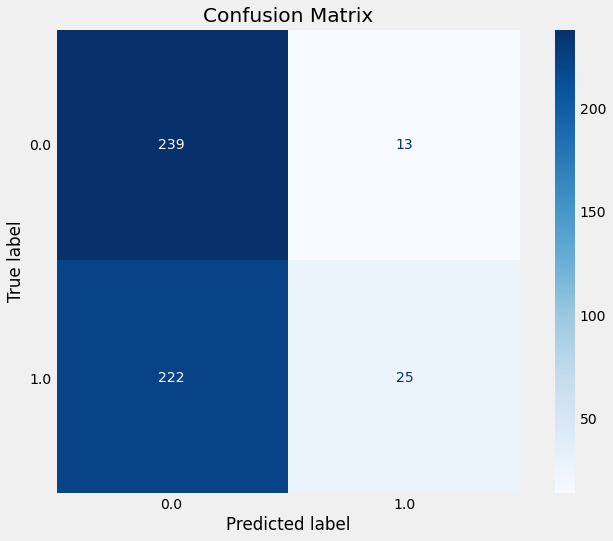

In [15]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10,8))
plot_confusion_matrix(pipe, X_test, y_test, ax=ax, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

- **B.6.3 Classification Report**

In [16]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.95      0.67       252
         1.0       0.66      0.10      0.18       247

    accuracy                           0.53       499
   macro avg       0.59      0.52      0.42       499
weighted avg       0.59      0.53      0.43       499



- **B.6.4 Area under ROC Curve**

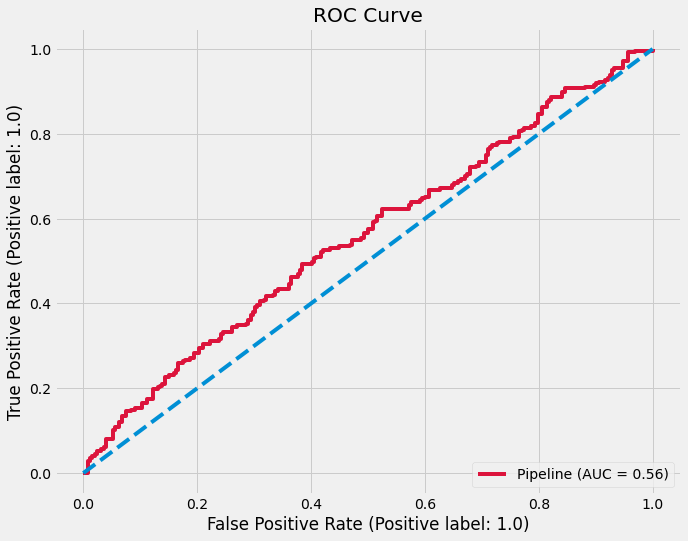

In [17]:
# plot ROC curve
fig, ax = plt.subplots(figsize=(10,8))
plot_roc_curve(pipe, X_test, y_test, ax=ax, color='crimson')
ax.plot([0,1], [0,1], linestyle='--')
ax.set_title('ROC Curve');

### B.7 Backtesting and Trading Strategy

- **B.7.1 Without Short Position**

In [18]:
# Create a new dataframe to subsume outsample data
df1 = data[-len(y_test):]

# Predict the signal and store in predicted signal column
df1['Signal'] = y_pred
    
# Calculate the strategy returns
df1['Strategy'] = df1['1D_Return'] * df1['Signal'].shift(1).fillna(0)

# Localize index for pyfolio
df1.index = pd.to_datetime(df1.index)

# Check the output
df1[['1D_Return', 'Signal', 'Strategy']].tail(10)

,1D_Return,Signal,Strategy
Date,,,
2022-09-16,0.005534,0.0,0.000000
2022-09-19,0.000770,0.0,0.000000
2022-09-20,-0.005723,0.0,-0.000000
2022-09-21,0.004632,0.0,0.000000
2022-09-22,-0.000578,0.0,-0.000000
2022-09-23,-0.017428,0.0,-0.000000
2022-09-26,-0.011701,1.0,-0.000000
2022-09-27,0.002048,1.0,0.002048
2022-09-28,0.020574,0.0,0.020574


Start date,2020-10-07
End date,2022-09-29
Total months,23
,Backtest
Annual return,4.377%
Cumulative returns,8.852%
Annual volatility,4.876%
Sharpe ratio,0.90
Calmar ratio,1.25
Stability,0.91
Max drawdown,-3.506%


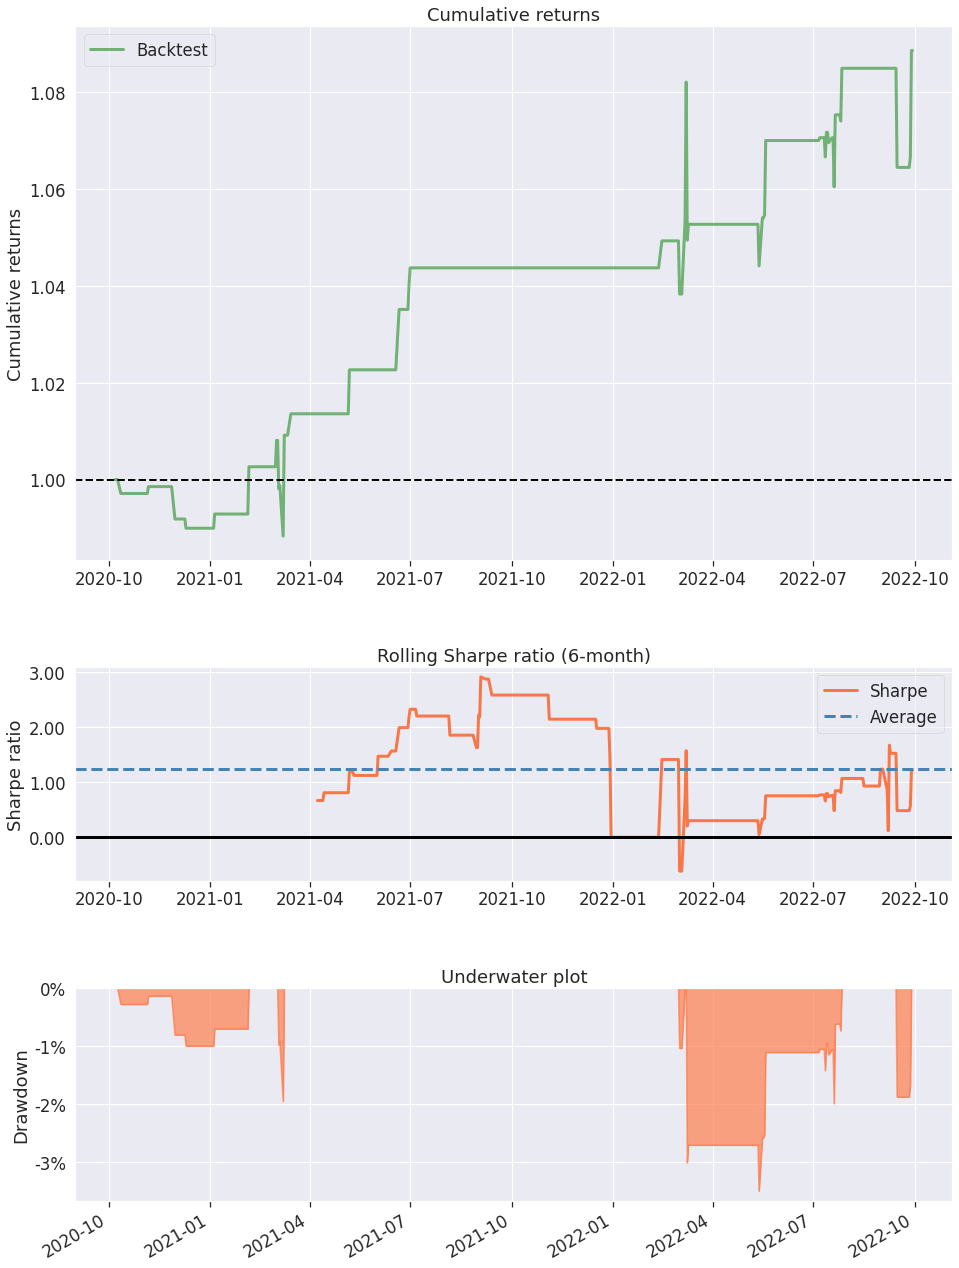

In [19]:
# Import pyfolio
import pyfolio as pf

# Create Tear sheet using pyfolio for outsample - for X_test
pf.create_simple_tear_sheet(df1['Strategy'])

In [20]:
df1['1D_Return'].sum(), df1['Strategy'].sum()

(-0.13661404743321642, 0.0871745090720001)

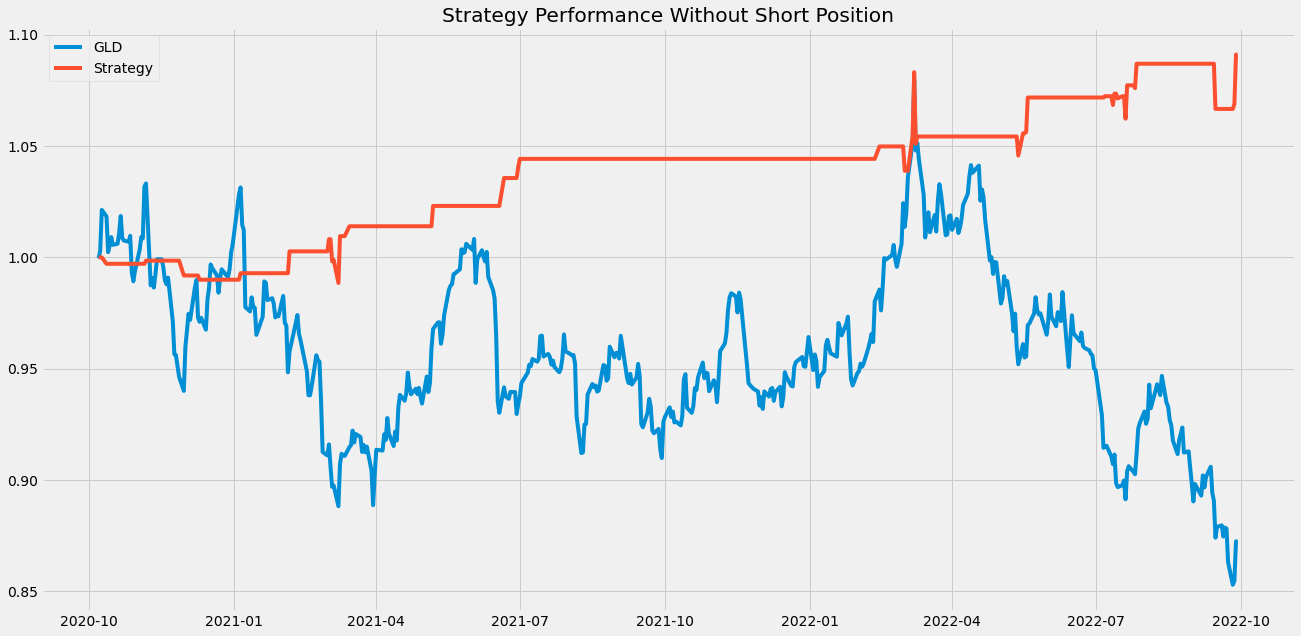

In [21]:
# Visualize
cumret = df1['1D_Return'].cumsum().apply(np.exp)
cumstg = df1['Strategy'].cumsum().apply(np.exp)

plt.figure(figsize=(20,10))
plt.plot(cumret, label ='GLD')
plt.plot(cumstg, label ='Strategy')
plt.legend()
plt.title('Strategy Performance Without Short Position');

In [22]:
print("The cumulative return of 'buy and hold' during the period is ", round((cumret[-1]-1)*100, 2), "%")
print("The cumulative return of the strategy (no short) during the period is ", round((cumstg[-1]-1)*100, 2), "%")

The cumulative return of 'buy and hold' during the period is  -12.77 %
The cumulative return of the strategy (no short) during the period is  9.11 %


- **B.7.2 With Short Position**

In [23]:
y_pred_ = y_pred.copy()
y_pred_[y_pred_==0] = -1

In [24]:
# Create a new dataframe to subsume outsample data
df2 = data[-len(y_test):]

# Predict the signal and store in predicted signal column
df2['Signal'] = y_pred_
    
# Calculate the strategy returns
df2['Strategy'] = df2['1D_Return'] * df2['Signal'].shift(1).fillna(0)

# Localize index for pyfolio
df2.index = pd.to_datetime(df1.index)

# Check the output
df2[['1D_Return', 'Signal', 'Strategy']].tail(10)

,1D_Return,Signal,Strategy
Date,,,
2022-09-16,0.005534,-1.0,-0.005534
2022-09-19,0.000770,-1.0,-0.000770
2022-09-20,-0.005723,-1.0,0.005723
2022-09-21,0.004632,-1.0,-0.004632
2022-09-22,-0.000578,-1.0,0.000578
2022-09-23,-0.017428,-1.0,0.017428
2022-09-26,-0.011701,1.0,0.011701
2022-09-27,0.002048,1.0,0.002048
2022-09-28,0.020574,-1.0,0.020574


Start date,2020-10-07
End date,2022-09-29
Total months,23
,Backtest
Annual return,15.774%
Cumulative returns,33.647%
Annual volatility,14.395%
Sharpe ratio,1.09
Calmar ratio,1.18
Stability,0.62
Max drawdown,-13.358%


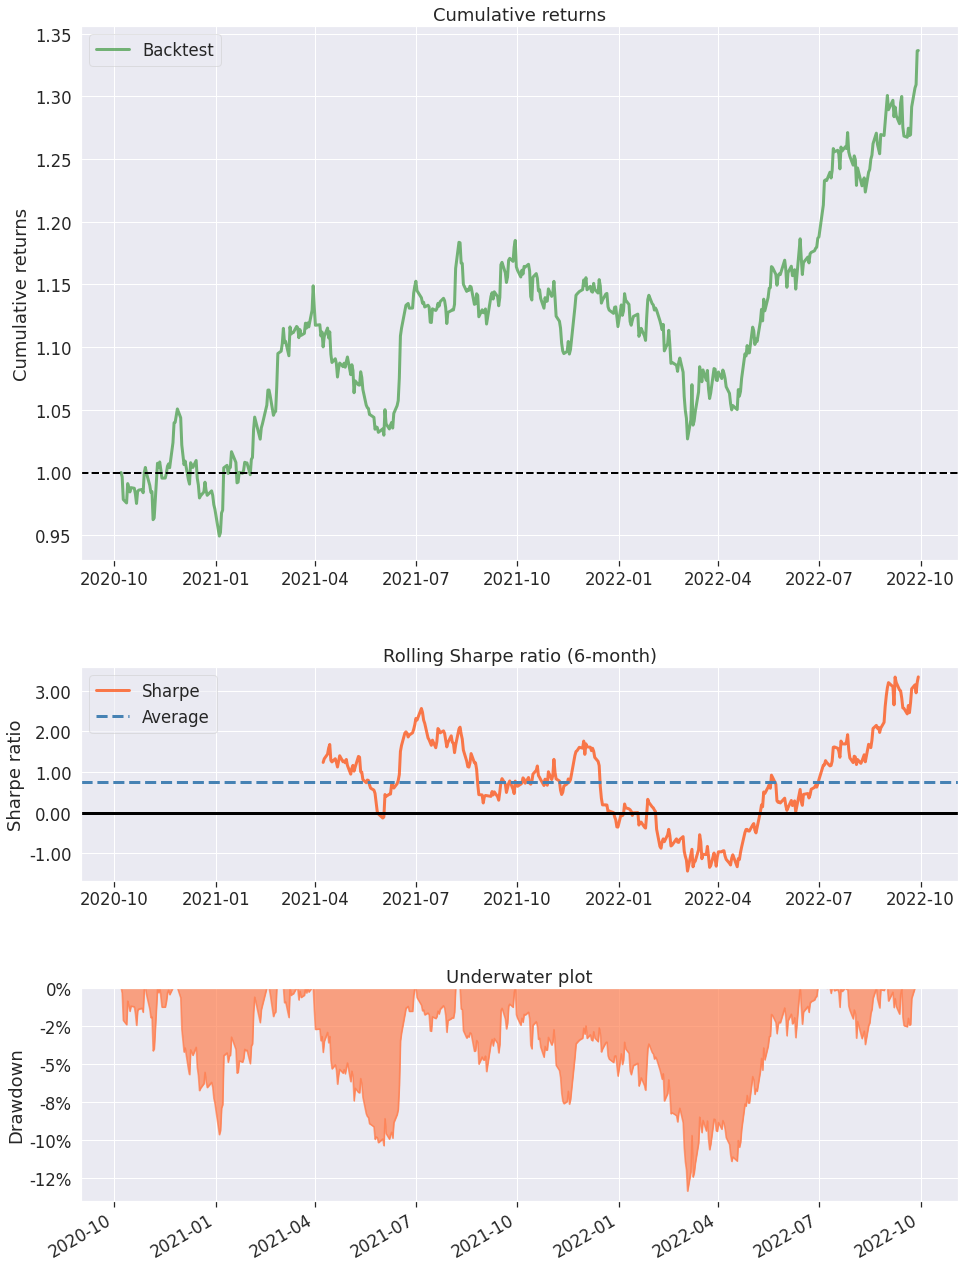

In [25]:
# Create Tear sheet using pyfolio for outsample - for X_test
pf.create_simple_tear_sheet(df2['Strategy'])

In [26]:
df2['1D_Return'].sum(), df2['Strategy'].sum()

(-0.13661404743321642, 0.310511740791882)

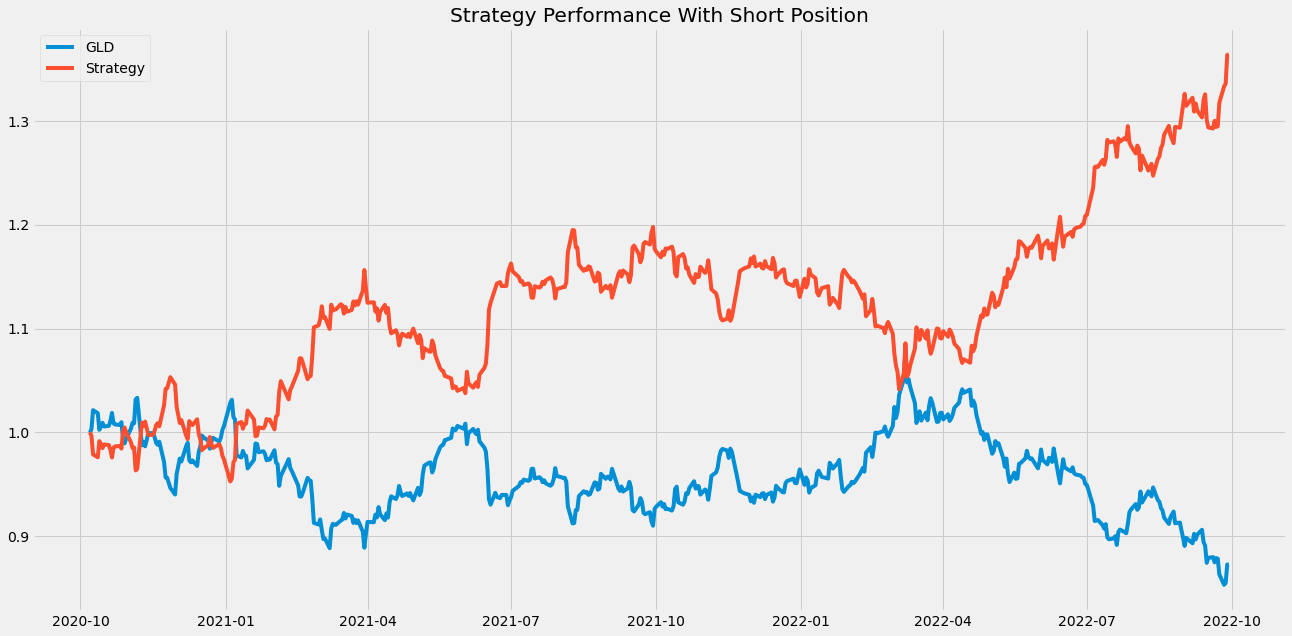

In [27]:
# Visualize
cumret_ = df2['1D_Return'].cumsum().apply(np.exp)
cumstg_ = df2['Strategy'].cumsum().apply(np.exp)

plt.figure(figsize=(20,10))
plt.plot(cumret_, label ='GLD')
plt.plot(cumstg_, label ='Strategy')
plt.legend()
plt.title('Strategy Performance With Short Position');

In [28]:
print("The cumulative return of 'buy and hold' during the period is ", round((cumret_[-1]-1)*100, 2), "%")
print("The cumulative return of the strategy (no short) during the period is ", round((cumstg_[-1]-1)*100, 2), "%")

The cumulative return of 'buy and hold' during the period is  -12.77 %
The cumulative return of the strategy (no short) during the period is  36.41 %
